In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors
from qs_mps.applications.Z2.utils import find_closest_value
from qs_mps.applications.Z2.relevant_observables import (
                                                         n_order_kink_mass_varying_g,
                                                         n_order_kink_mass_varying_R,
                                                         get_fit_params,  
                                                         string_width_chis,
                                                         string_width_varying_g,
                                                         string_width_varying_R,
                                                         entropy,
                                                        )
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 12}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
bc = "pbc"
cx = None
cy = None
sector = "2_particle(s)_sector"
Ls = [30]
L = 30

# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
path = "add_your_path_to_save_data"
path = "/Users/fradm/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/projects/1_Z2"
path_figures = "add_you_path_to_save_figures"
path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
path_figures = "D:/code/projects/1_Z2"

colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colors = ["#60A7F3","#9E76AB","#DC4563"]
colors = ["#4688CE","#916799","#DC4563"]
colors = ["#4688CE","#9B4DB7","#DC4563"]
# colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Potential

In [37]:
def plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=1):
    gammas, gammas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    plt.plot(gs, -np.asarray(gammas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=-np.asarray(gammas)-np.asarray(gammas_err),y2=-np.asarray(gammas)+np.asarray(gammas_err), color=color, alpha=0.4)

def plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=0):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    plt.plot(gs, np.asarray(sigmas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(sigmas)-np.asarray(sigmas_err),y2=np.asarray(sigmas)+np.asarray(sigmas_err), color=color, alpha=0.4)

def plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=2):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=0)
    deltas, deltas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    obs = - np.asarray(deltas)*np.asarray(sigmas)
    obs_err = np.sqrt((np.asarray(deltas)*np.asarray(sigmas_err))**2 + (np.asarray(sigmas)*np.asarray(deltas_err))**2)
    plt.plot(gs, obs, marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=obs-obs_err,y2=obs+obs_err, color=color, alpha=0.4)


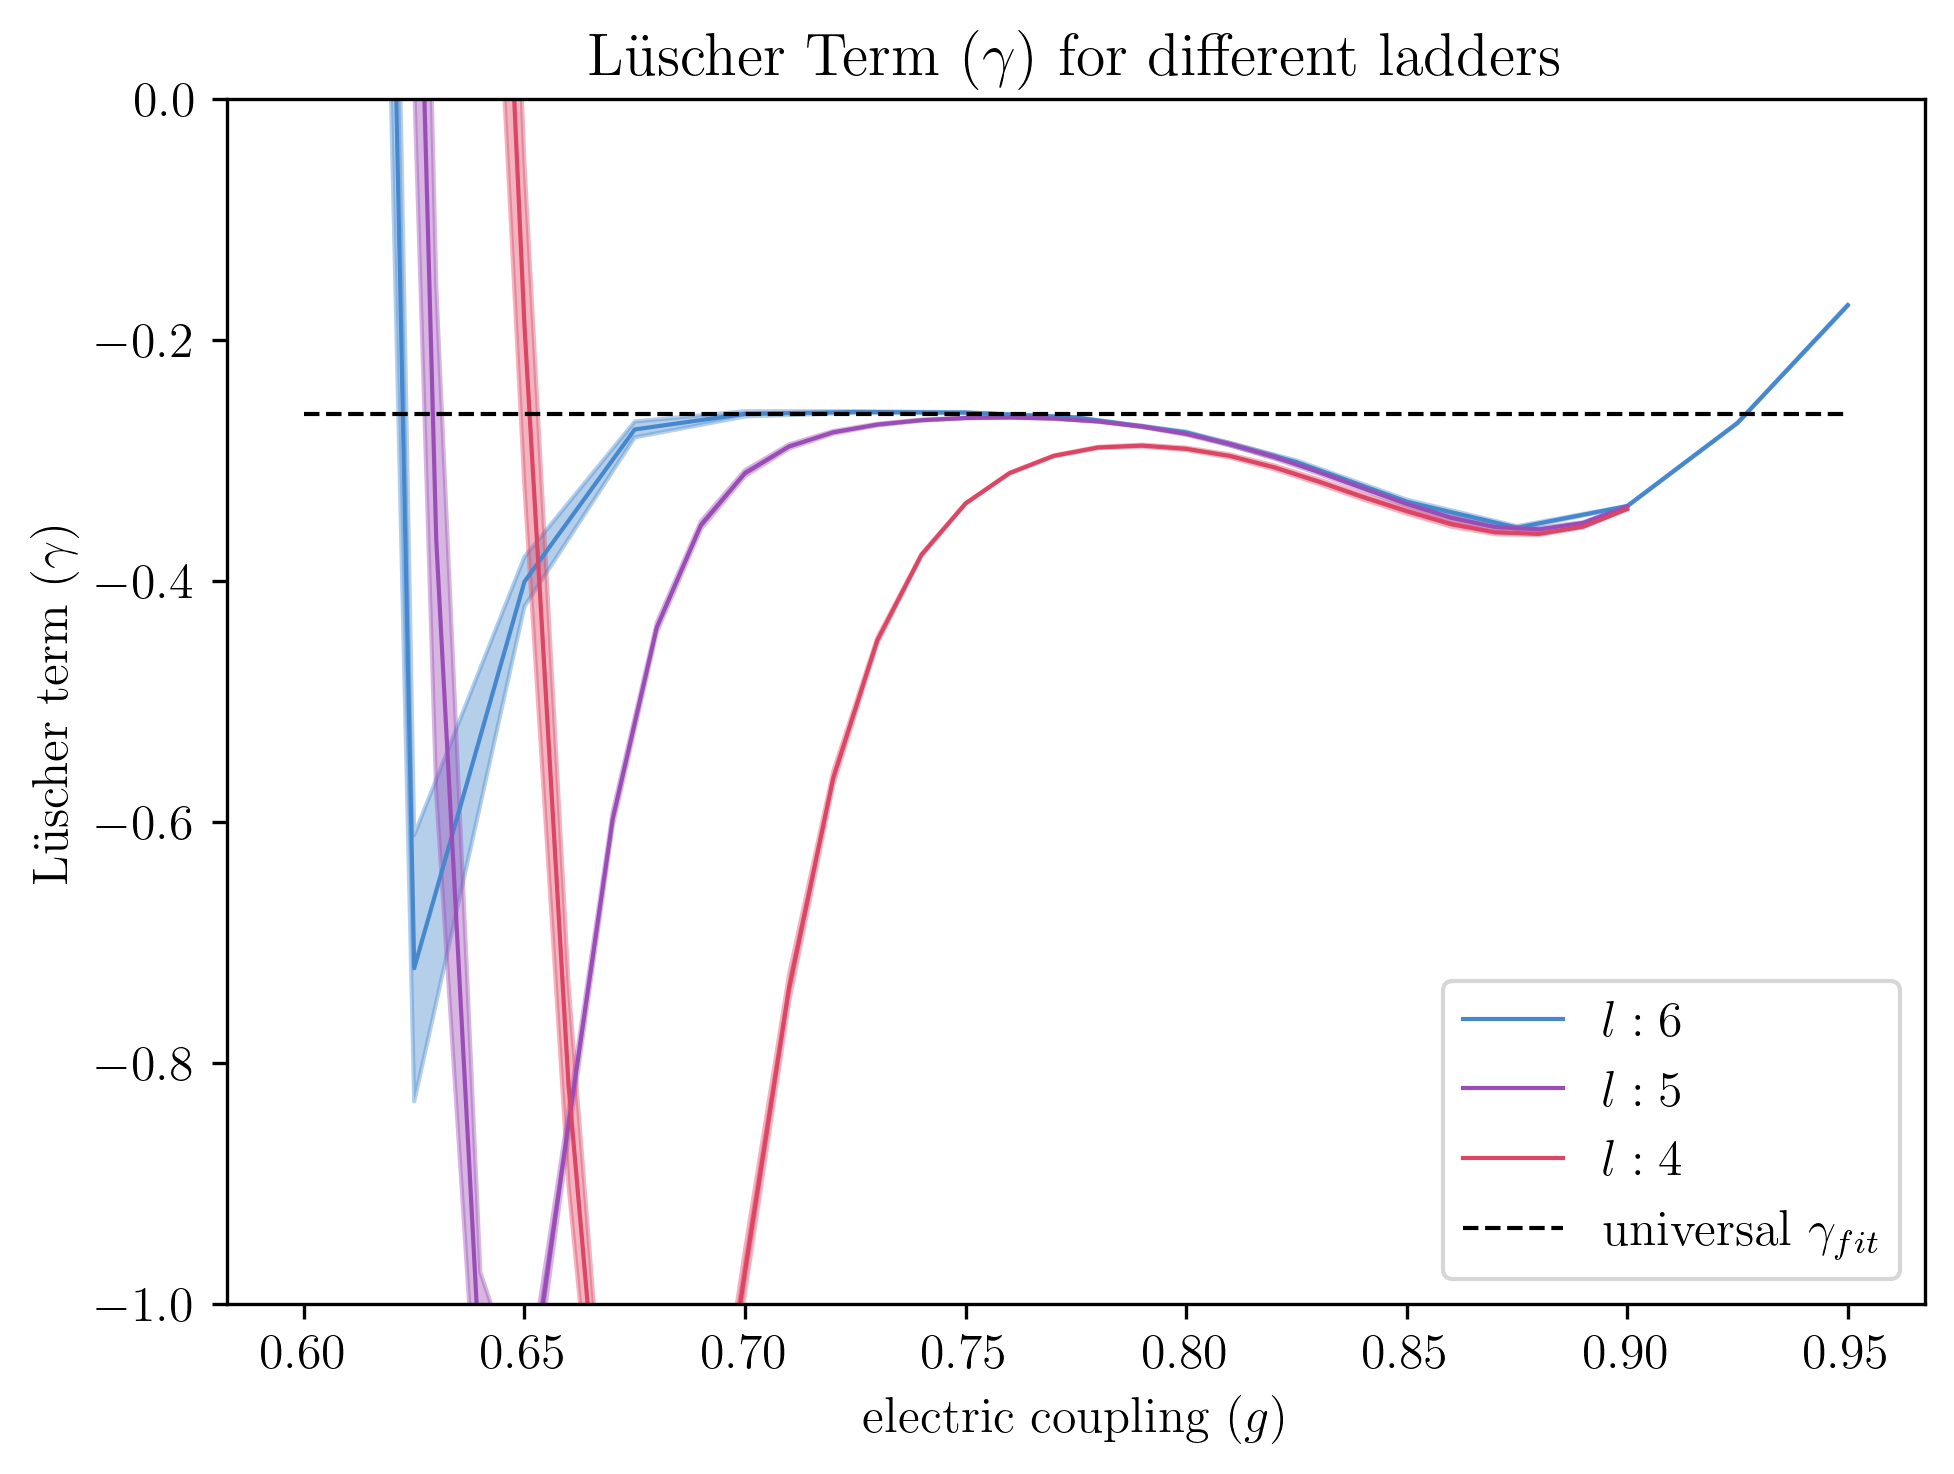

In [38]:
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [10,12,14,16,18,20,22,24]
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])



# plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=0.95, linestyles="--", colors='black', linewidth=1, label="universal $\\gamma_{fit}$")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
# plt.ylim((-1,0))
plt.ylim((-1,0))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("Lüscher term $(\\gamma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_34512/2601444693.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("String tension $(\sigma)$")


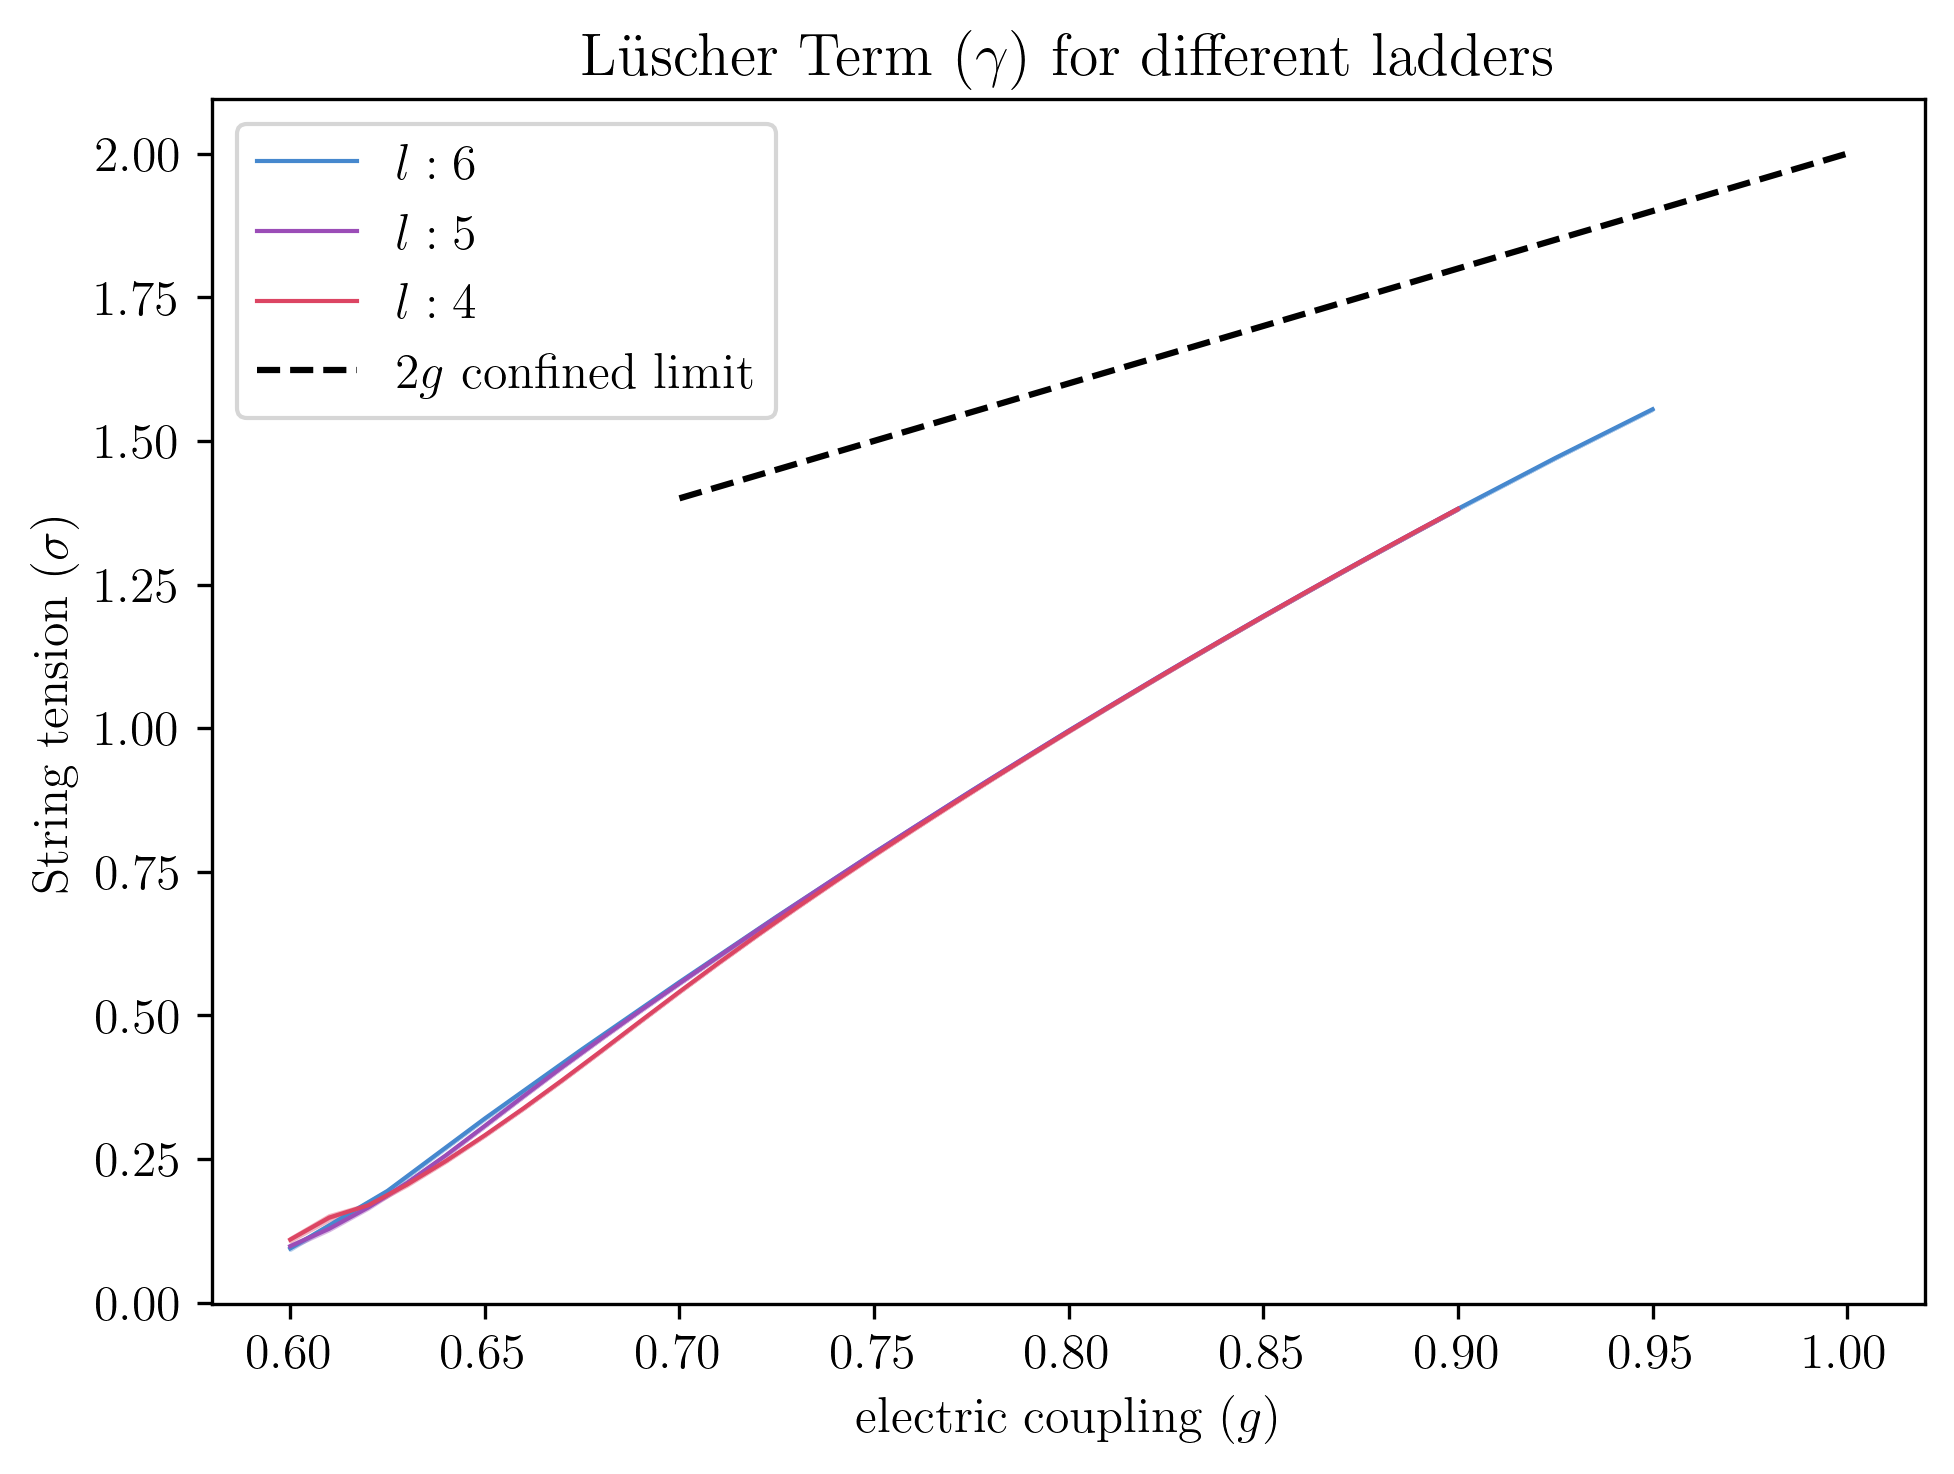

In [39]:
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])



x = np.linspace(0.7,1)
plt.plot(x,2*x, linestyle="--", color="black", label="$2g$ confined limit")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("String tension $(\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

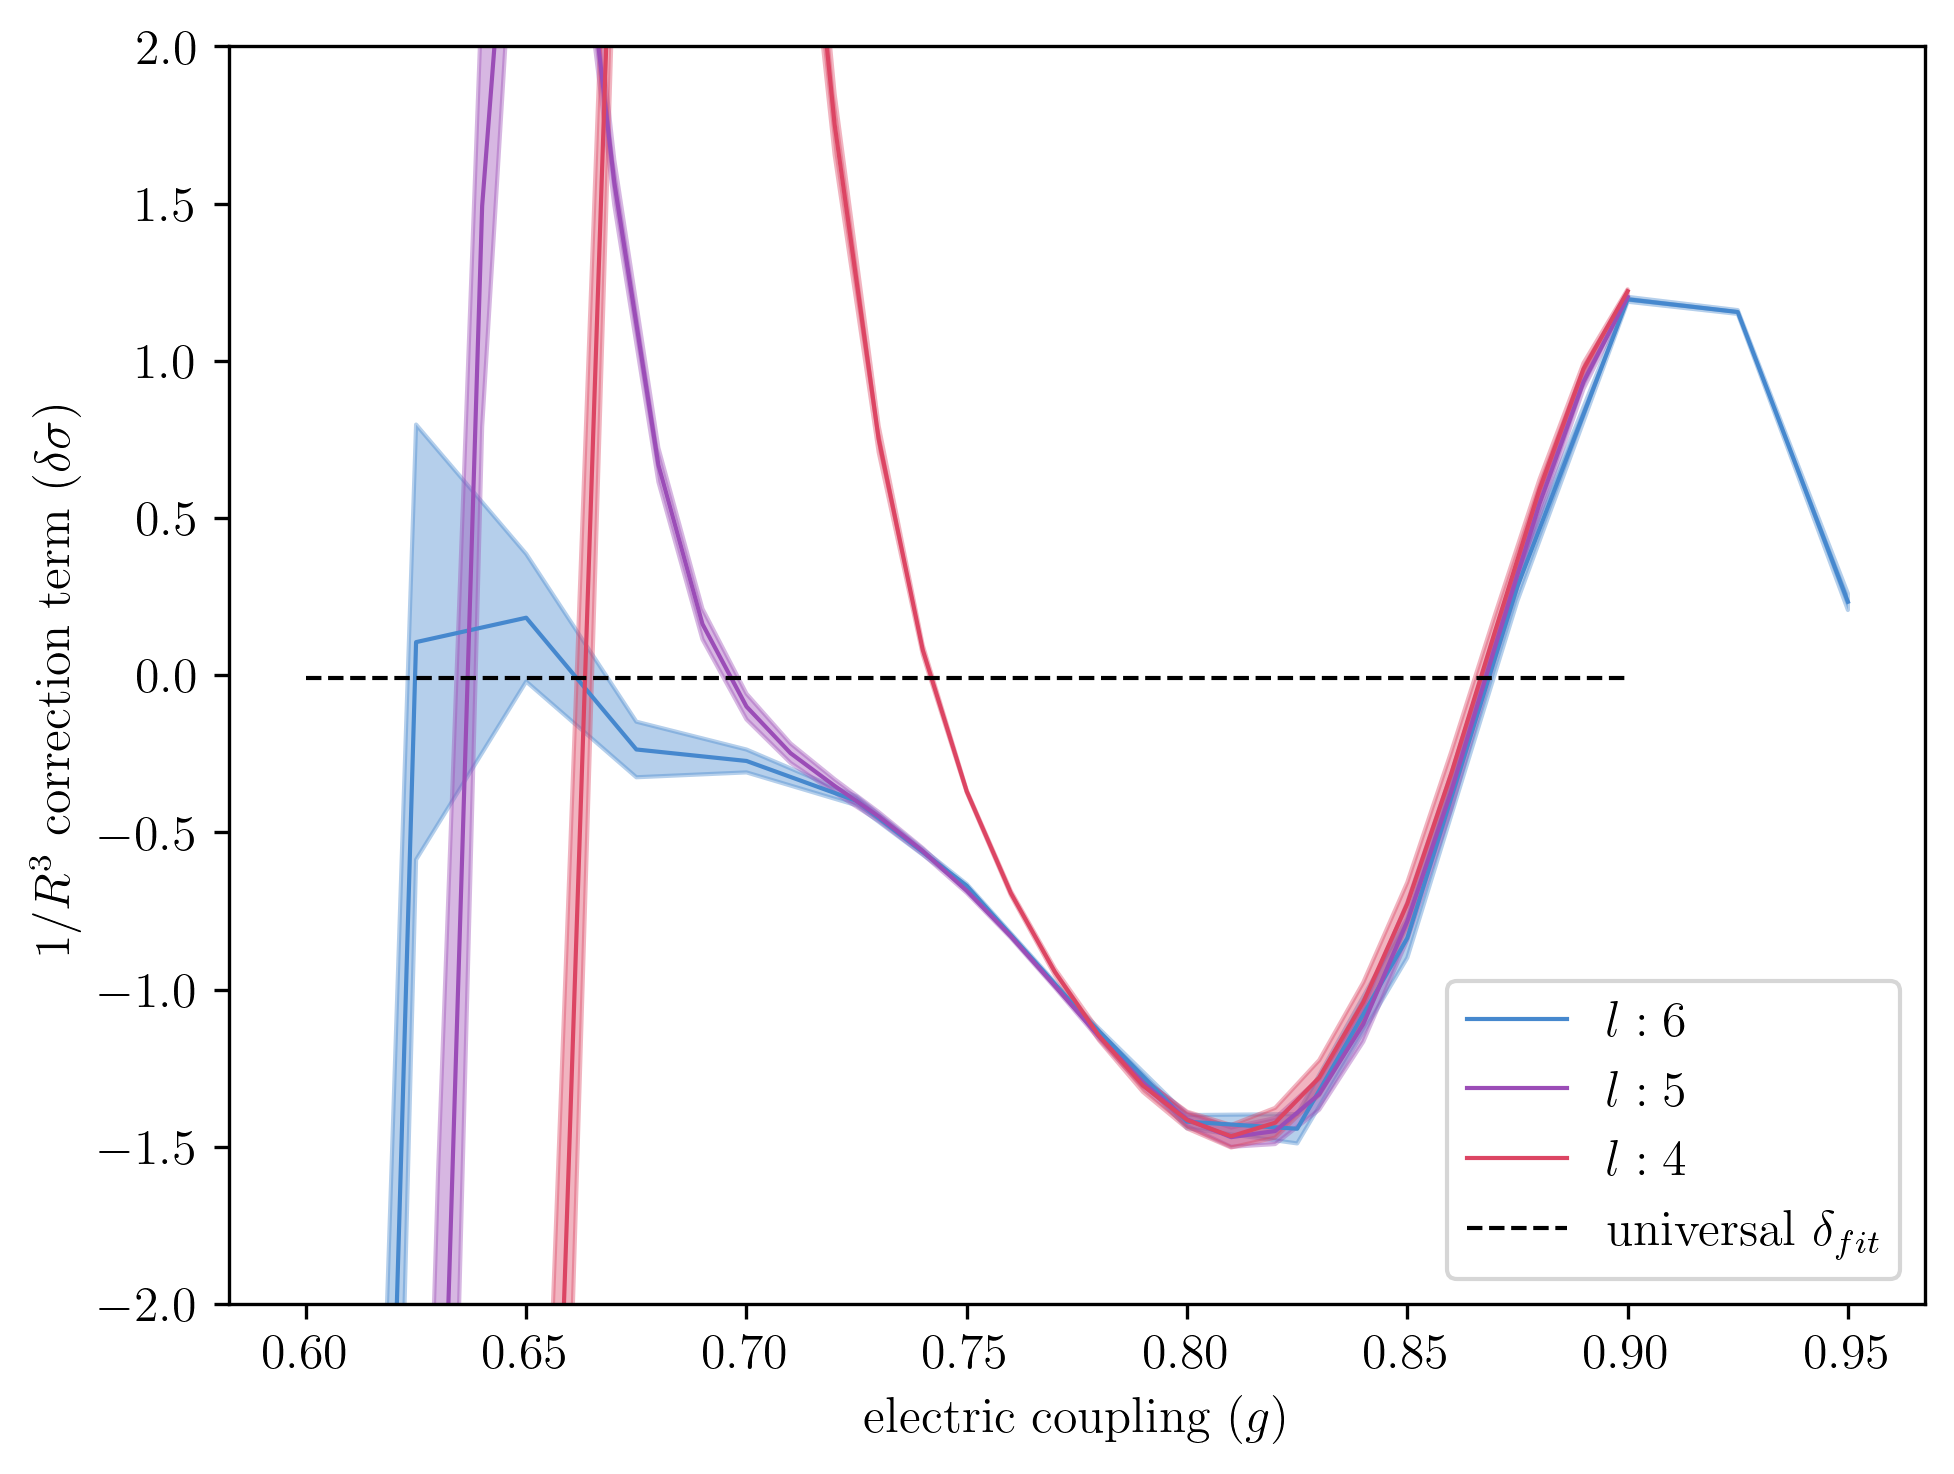

In [40]:
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])

plt.hlines(y=-(np.pi**2)/1152, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='black', linewidth=1, label="universal $\\delta_{fit}$")

# plt.grid(True)
plt.ylim(-2,2)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("$1/R^3$ correction term $(\\delta\\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/second_potential_correction_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

## String Width

<>:50: SyntaxWarning: invalid escape sequence '\i'
<>:50: SyntaxWarning: invalid escape sequence '\i'
C:\Users\HP\AppData\Local\Temp\ipykernel_25624\115216603.py:50: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")


g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g

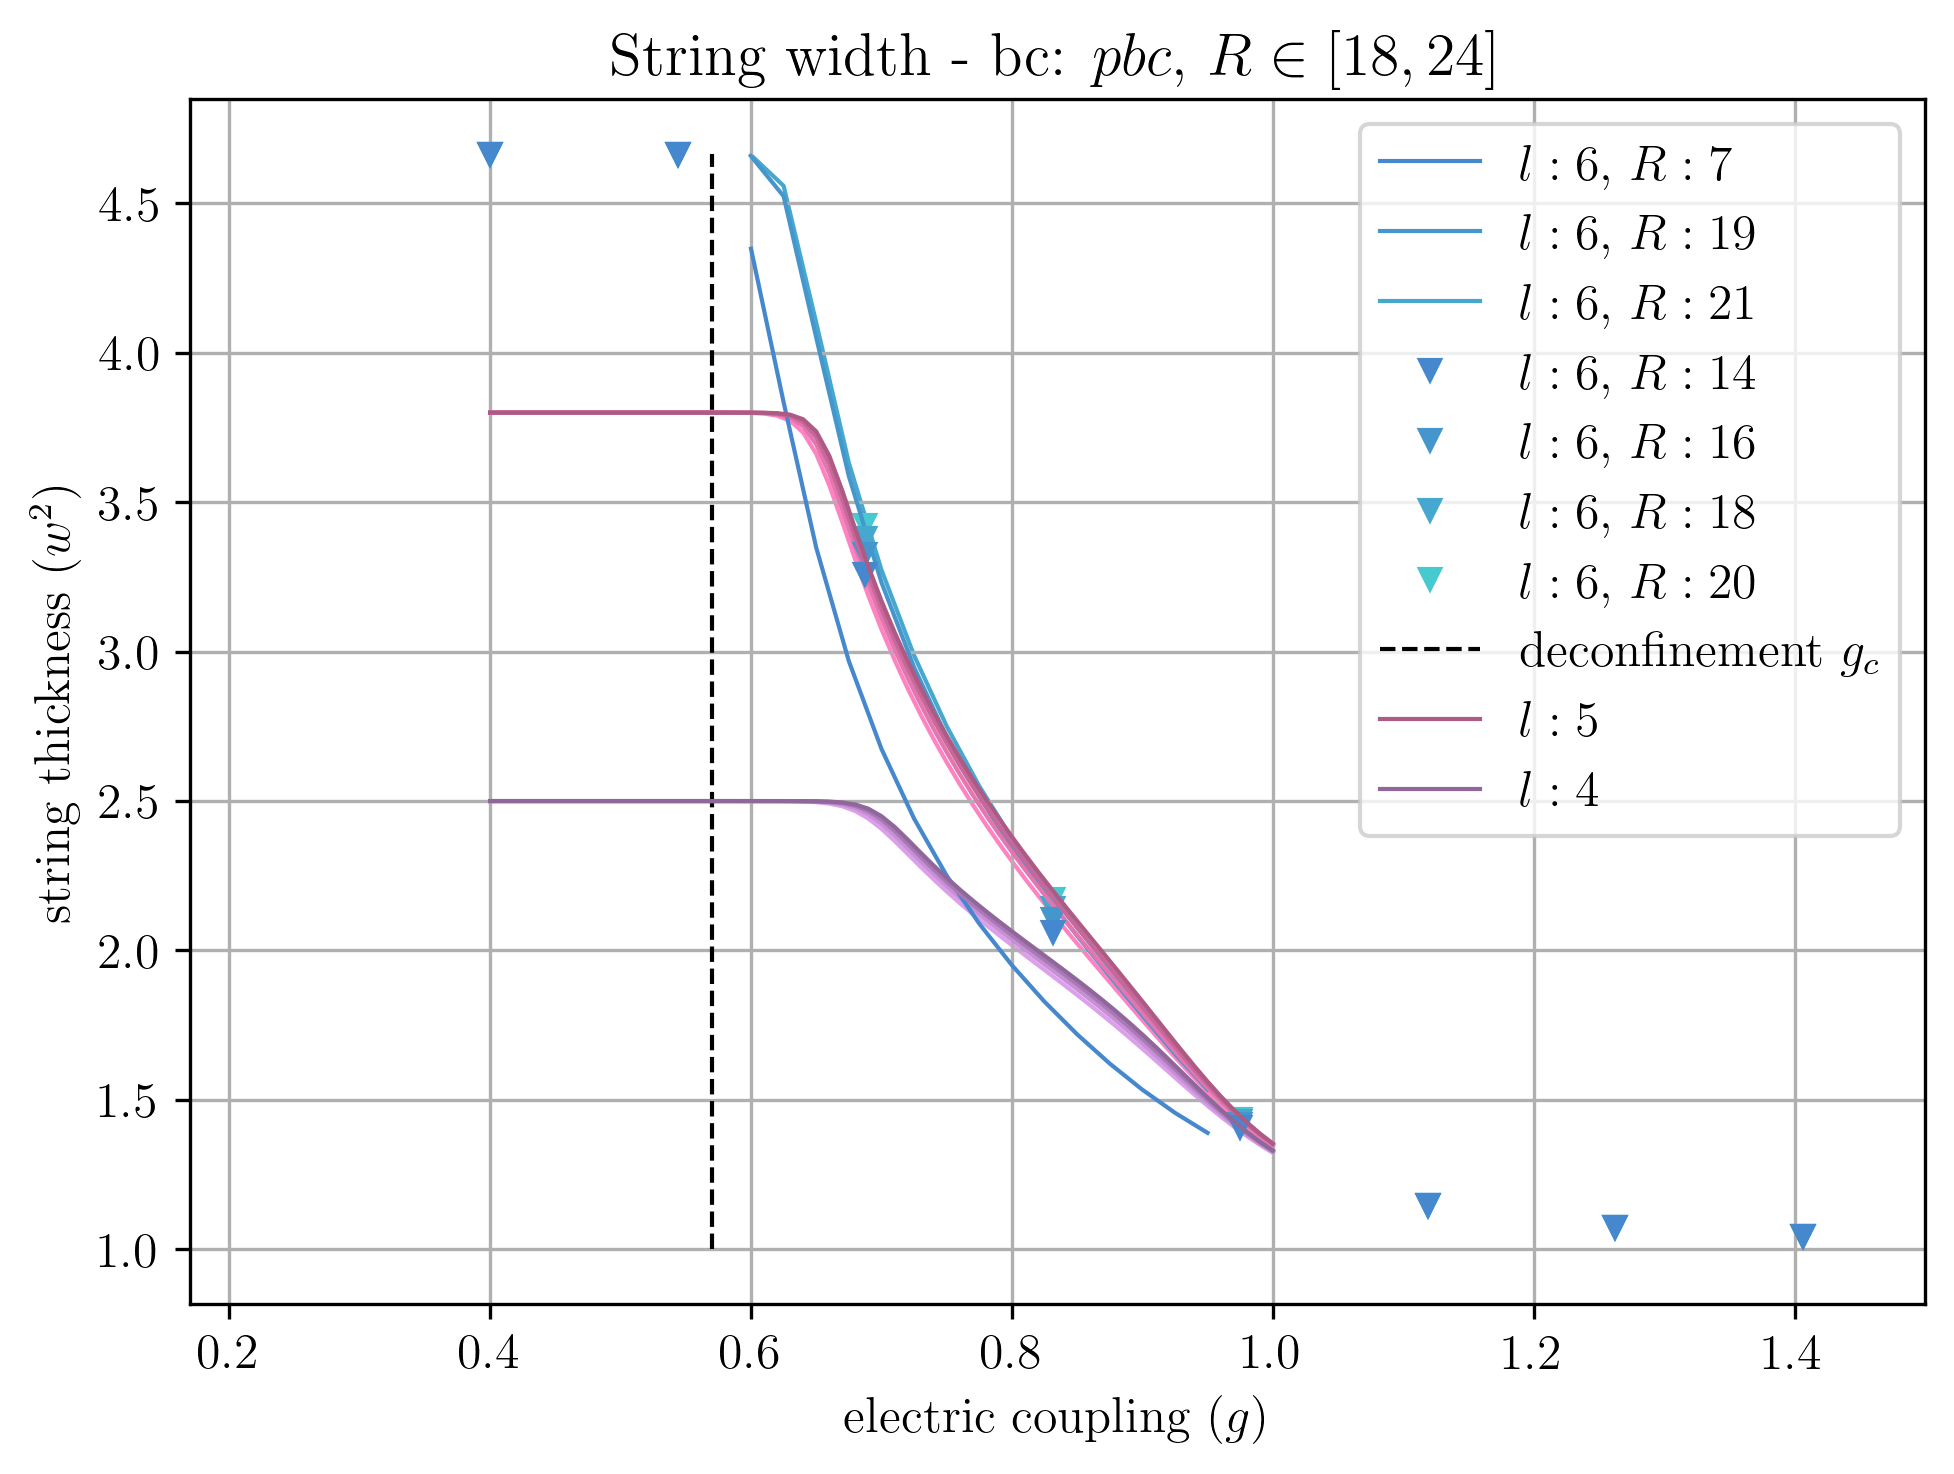

In [19]:
colors = ["#4688CE","#4696CE","#46A8CE","#46CACF"]
Rs = [19,21,23]
Rs.reverse()
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
bc = "pbc"
sector = "2_particle(s)_sector"
l = 6
L = 30
Ls = [30]
chis = [64,128]
Rs = [7,19,21]

for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rs = [14,16,18,20]
l = 6
for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i], linestyle="", linewidth=0, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i+j+1], alpha=0.4)

plt.vlines(x=0.57, ymin=1, ymax=max(ws), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

chis = [32,64]
Rs = [18,20,22,24]
Rs.reverse()
# colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#9B4DB7","#BC4FBE","#CC50C2","#DC51C5"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss = [["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
ls = [5,4]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
for colors, l in zip(colorss, ls):
    for i, R in enumerate(Rs):
        ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
        if R == 24:
            label = f"$l: {l}$"
        else: 
            label = None
        plt.plot(gs, ws, markersize=2, color=colors[i], linestyle="-", linewidth=1, label=label, zorder=len(Rs)-i)
        # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4, zorder=len(Rs)-i)

Rs.reverse()
plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
# plt.xscale("log")
plt.xlim(right=1.5)
plt.legend()

[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]
[False, False, False]
[-1, 1, 2]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HP/Desktop/projects/1_Z2/results/energy_data/electric_energy_density_Z2_dual_direct_lattice_6x30_2_particle(s)_sector_bc_pbc_[5, 24]-[0, 0]_h_0.4-1.0_delta_61_chi_64.npy'

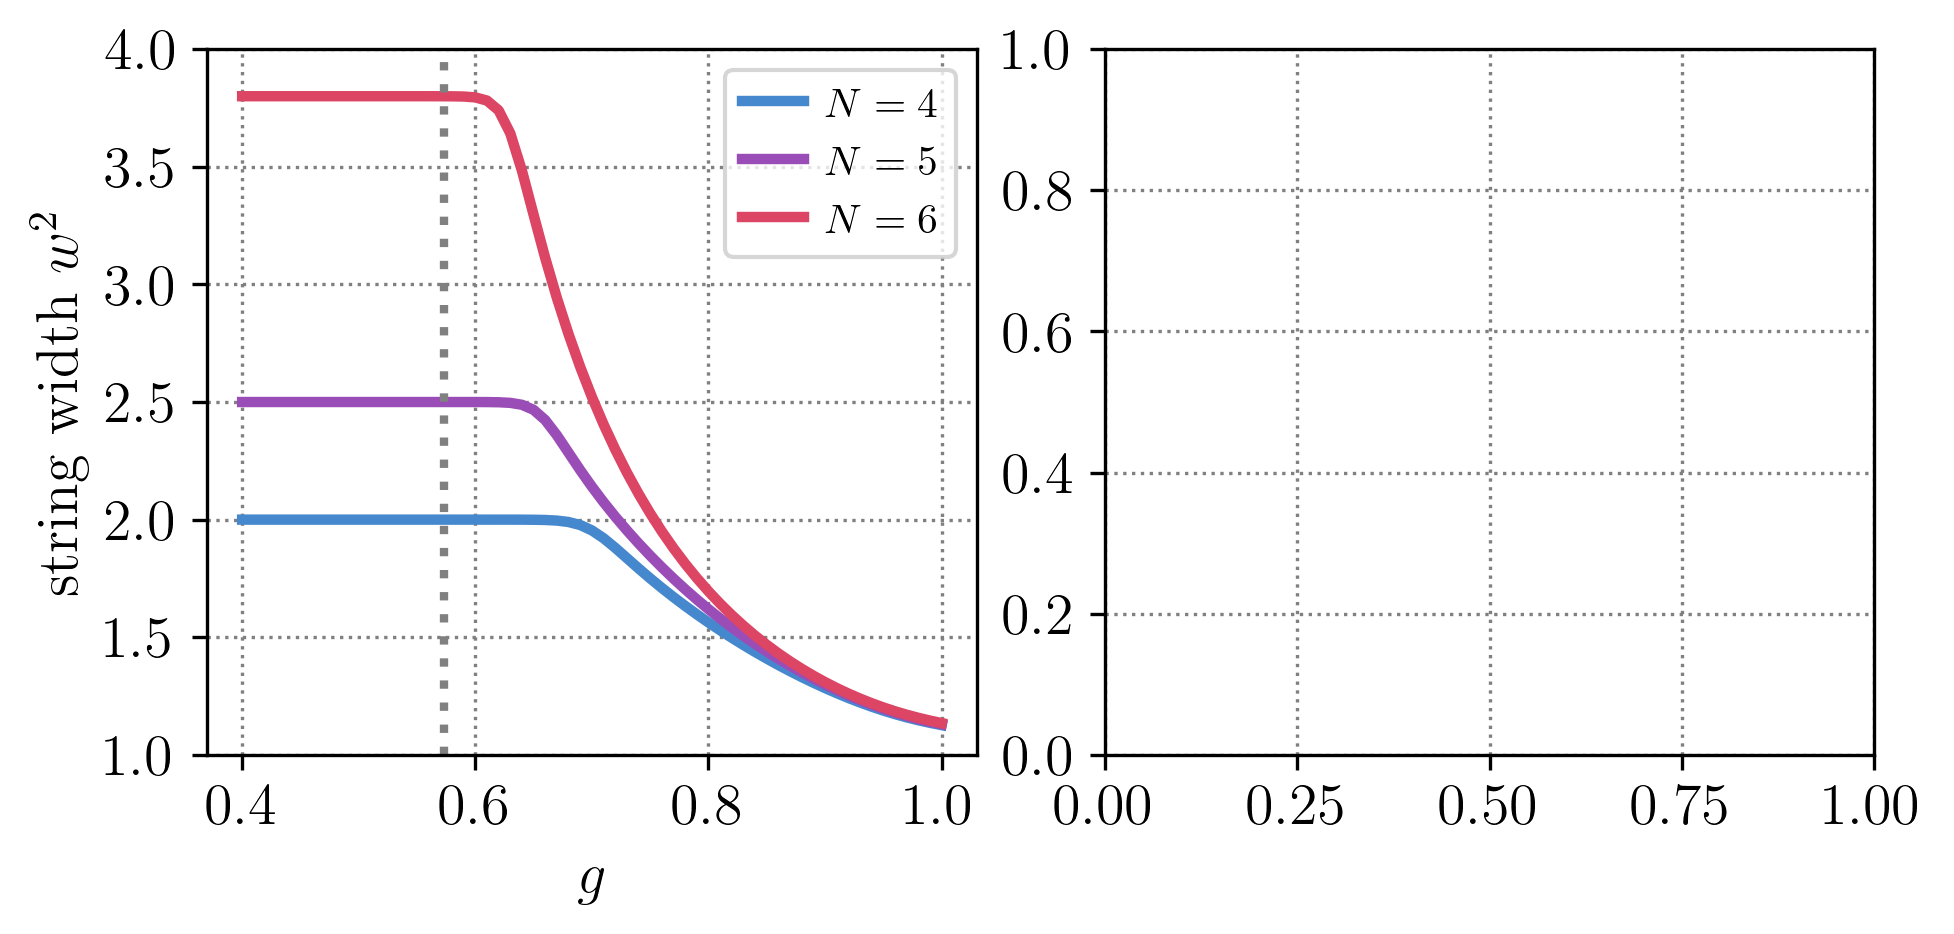

In [33]:
# Matplotlib settings

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    linestyle=':',
)

theor_gc = 1 / np.sqrt(3.04438)
theor_gc
R_max = [24,24,20]
Rs = [19,20]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

for ax in axs:
    ax.grid(color="gray", linestyle=":")

# String width vs coupling
i = 0
for N in [4, 5, 6]:
    Rmax = R_max[i]
    string_width, string_width_err = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    print(f"N = {N}, Rmax = {Rmax}")
    axs[0].plot(gs, string_width, color=colors[i], label=f"$N = {N}$", linewidth=2.5)
    i += 1
axs[0].legend()
axs[0].set_xlabel("$g$")
axs[0].set_ylabel("string width $w^2$")
axs[0].vlines(theor_gc, 1, 4, 'grey', ':', linewidth=2)
axs[0].set_ylim(1, 4)

# String width vs separation R
for g in [1.0, 0.9, 0.8, 0.7, 0.4]:
    string_width, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path)
    axs[1].plot(Rs, string_width, label=f"$g = {g}$", **marker_opts)
axs[1].set_xlabel("$R$")
axs[1].set_ylabel("string width $w^2$")
axs[1].legend(loc="upper left")
axs[1].text(18, 1.5, f"$N = {N}$")

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/string_width.pdf", bbox_inches='tight')